# Biocreative V Task 3B: discovering drug-induced diseases from primary text using crowdsourcing

2015-06-10 Tong Shu Li<br>
Last updated 2015-06-29

We will create the work units we need for CrowdFlower in this notebook.

First we will need to parse out the data into something useable.

In [1]:
from collections import Counter
from collections import defaultdict
import matplotlib as plt
import pandas as pd
import random
import sys

In [2]:
random.seed("2015-06-11:14:46")

In [3]:
%matplotlib inline

In [4]:
sys.path.append("/home/toby/Code/util/")
from file_util import read_file
from web_util import add_simple_tag

from src.get_pubmed_abstract import get_abstract_information

from src.parse_gold import parse_input

---

### Parse the input files and split into individual papers:

In [5]:
sample_data = parse_input("data/training", "CDR_sample.txt")

In [6]:
training_data = parse_input("data/training", "CDR_TrainingSet.txt")

In [7]:
development_data = parse_input("data/development", "CDR_DevelopmentSet.txt")

Number of papers in each dataset:

In [8]:
print len(sample_data)
print len(training_data)
print len(development_data)

50
500
500


---

Let's check that each drug-disease relation only has one identifier each:

In [9]:
def is_mesh_id(mesh_id):
    return len(mesh_id) == 7 and mesh_id[0] in ['C', 'D']

In [10]:
def check(dataset):
    for paper in dataset:
        for relation in paper.relations:
            assert len(relation.drug.split('|')) == 1
            assert len(relation.disease.split('|')) == 1
            assert is_mesh_id(relation.drug), paper.pmid
            assert is_mesh_id(relation.disease)

In [11]:
check(sample_data)

In [12]:
check(training_data)

In [13]:
check(development_data)

---

## Check for each annotation in each paper that the indicies of text mentioned actually match what it should be:

In [14]:
def check_paper_annotations(paper):
    """
    Makes sure that the annotations for a paper are correct.
    """
    text = "{0} {1}".format(paper.title, paper.abstract)
    for annotation in paper.annotations:
        assert text[annotation.start : annotation.stop] == annotation.text

In [15]:
datasets = [sample_data, training_data, development_data]
for dataset in datasets:
    for paper in dataset:
        check_paper_annotations(paper)

Thankfully there are no errors in the highlighting of annotations. This is a relief.

### Now let's check that the drugs and diseases don't overlap with one another:

In [16]:
def separate(sub, obj):
    return sub.start > obj.stop or obj.start > sub.stop

def check_separate(paper):
    for i, sub in enumerate(paper.annotations):
        for j, obj in enumerate(paper.annotations):
            if i != j:
                assert separate(sub, obj)
                
def check_no_overlap(dataset):
    for paper in dataset:
        check_separate(paper)

In [17]:
check_no_overlap(training_data)

In [18]:
check_no_overlap(development_data)

In [19]:
def check_drug_disease_overlap(paper):
    """
    Check to see that all pairs of drug-disease do not overlap each other.
    """
    # drugs and diseases don't overlap
    # but, diseases may overlap with other diseases, and same for drugs
    # happens when the identifiers are the same or different
  
    # the code below fails the assertion, but that's ok
    # sample data pmid 9660111 937, 939 
    for i, sub in enumerate(paper.annotations):
        for j, obj in enumerate(paper.annotations):
            if sub.uid != obj.uid:
                assert sub.start > obj.stop or obj.start > sub.stop, "pmid {0} sub {1} obj {2}".format(paper.pmid,
                                                                                                       sub.start,
                                                                                                       obj.start)
    
    for drug in paper.annotations:
        if drug.stype == "chemical":
            for disease in paper.annotations:
                if disease.stype == "disease":
                    assert drug.start > disease.stop or disease.start > drug.stop

In [20]:
datasets = [sample_data, training_data, development_data]
for i, dataset in enumerate(datasets):
#     print i
    for paper in dataset:
        check_drug_disease_overlap(paper)

These data are very clean. There will be no highlighting problems down the line. The only difficulty is that some concepts might be subset of other concepts in terms of highlighting.

---

### How many annotations and relations does each paper have?

In [21]:
def info(papers):
    points = []
    for paper in papers:
        points.append((len(paper.annotations), len(paper.relations)))
        
    df = pd.DataFrame(points, columns = ["annotations", "relations"])    
    df.plot(figsize = (10, 5))

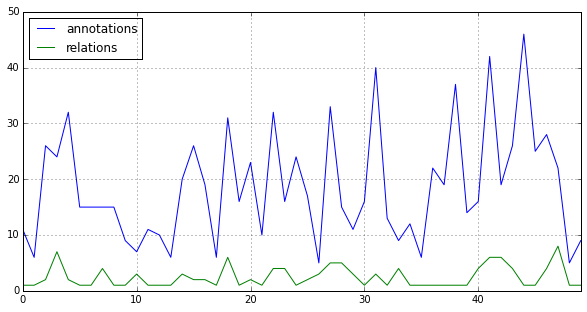

In [22]:
info(sample_data)

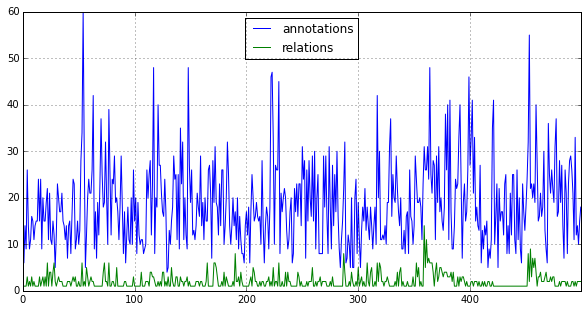

In [23]:
info(training_data)

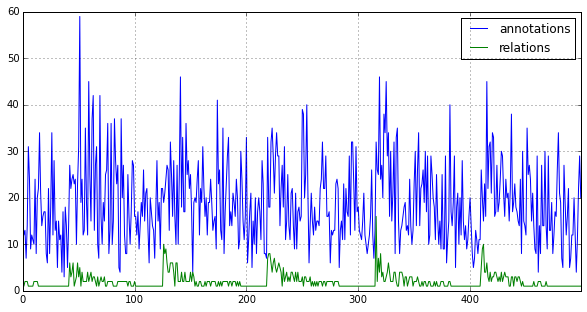

In [24]:
info(development_data)

### I've noticed that some of the annotations for diseases or drugs will have an identifier of "-1". I presume that this is because some of the concepts have not yet been assigned identifiers. However, since the relationships given seem to be only based on the identifiers, I was wondering if the concepts without identifiers will every be involved in a relationship. If they are, are they mentioned by name, or by something else?

It seems that indeed there are no relationships between concepts without identifiers in any of the provided data. I will therefore assume that there will never be any relationships involving concepts without any identifier. Therefore, it seems that any annotations where there is no identifier can be ignored for the purposes of trying to find all of the relationships. This is good, because it will reduce the possible number of work units, making the job cheaper.

Therefore we can now ignore the concepts with no identifiers for our project.

## How much would it roughly cost to do the pairwise expansion experiment?

If, for each paper, we show the crowd all N by M unique drug-disease pairs, then how many work units will there be? This will give us a rough idea of the cost of the experiment.

In [25]:
def num_work_units(papers):
    work_units = 0
    for paper in papers:
        uniq_drugs = set()
        uniq_diseases = set()
        for annotation in paper.annotations:
            if annotation.stype == "chemical":
                uniq_drugs.add(annotation.uid)
            else:
                assert annotation.stype == "disease"
                uniq_diseases.add(annotation.uid)

        work_units += len(uniq_drugs) * len(uniq_diseases)

    return work_units

In [26]:
num_work_units(sample_data)

672

In [27]:
num_work_units(training_data)

5399

In [28]:
num_work_units(development_data)

5175

So 5000 work units for 500 papers equals 10 work units (WU) per paper on average. If, we formulate the crowd task as follows:
1. Read an abstract.
2. Answer 5 true/false questions regarding 5 unique drug-disease pairs, about whether the drug is inducing the disease.

Pay 10 cents per task (5 work units), so 2 cents per work unit. Ask for 5 user judgements per any task.

The cost per paper would therefore be: 2 cents/WU/judgement * 10 WU/paper * 5 judgements = $1.00 per paper

### Therefore the cost seems reasonable per paper. Let's actually try out a small experiment to see if people can actually do this job at all:

We will be measuring two things: precision and recall. Recall = % of the relations that the crowd managed to get correct / total number of relations. Precision = # of relations / # of relations + # of relations crowd says exists but are wrong

### Selecting a random sample of papers to use for our experiment:

Since the sample set (50 papers) is just a small subset of the actual training set, we will just go ahead and pick directly from the training set for simplicity.

In [29]:
TESTSET_SIZE = 30
testset = random.sample(training_data, TESTSET_SIZE)

for paper in testset:
    print paper.pmid

11569530
11135224
1378968
19269743
8595686
16337777
10520387
17931375
3800626
9522143
17241784
2265898
6666578
15632880
8590259
12198388
2515254
1835291
12041669
7582165
2096243
7449470
2375138
6692345
17261653
18631865
1130930
10835440
15602202
16167916


Now we need to generate the actual work units for CrowdFlower:

We will need for each work unit:

1. A unique work unit id.
2. The title of the paper, properly highlighted with diseases and drugs.
3. The body of the abstract, properly highlighted.
4. A set of 5 (too many?) unique drug-disease pairs. (include proper names for each concept?)
    1. If there aren't enough, then make it blank and display nothing in crowdflower.


In [30]:
def chunks(a_list, chunk_size):
    """
    Yield successive chunks from the list.
    """
    for i in xrange(0, len(a_list), chunk_size):
        yield a_list[i : i + chunk_size]

In [31]:
def get_all_work_units(paper):
    """
    Generate all unique drug-disease pairs by unique identifier.
    Return a list.
    
    Also gives a name to each drug or disease.
    """
    uniq = defaultdict(set)
    for annotation in paper.annotations:
        uniq[annotation.stype].add(annotation.uid)
        
    assert len(uniq["chemical"]) <= 15
    assert len(uniq["disease"]) <= 10
        
    name = dict()
    for i, drug in enumerate(uniq["chemical"]):
        name[drug] = "[chemical {0}]".format(chr(ord("A") + i))
        
    for i, disease in enumerate(uniq["disease"]):
        name[disease] = "[disease {0}]".format(chr(ord("P") + i))
        
    return ([(drug, disease) for drug in uniq["chemical"] for disease in uniq["disease"]], name)

In general there may be many unique diseases and chemicals in any one abstract, so we will need to watch out for those later on when we make the streaming API. The max was 16 diseases and 16 chemicals per any one abstract.

##For our small testset of 30 papers, it was ok to start chemicals at A and diseases at P. In the future we will need to update this since in the larger testset this is not true.

In [32]:
def is_subset(concept, other):
    """
    Checks if the first concept is a subset of the position of the second concept.
    """
    return concept.start >= other.start and concept.stop <= other.stop

In [33]:
def get_uniq_spans(paper, group):
    """
    Looks through all of the text spans which need to be
    highlighted, and removes those which are subsets of
    another span that needs to be highlighted.
    """
    concepts = set()
    for drug, disease in group:
        concepts.add(drug)
        concepts.add(disease)

    highlight = []
    for annotation in paper.annotations:
        if annotation.uid in concepts:
            highlight.append(annotation)

    temp = []
    for i, annotation in enumerate(highlight):
        temp.append(annotation)

        for j, other in enumerate(highlight):
            if i != j and annotation.stype == other.stype:
                if is_subset(annotation, other):
                    raise Exception("this shouldn't happen")
                    temp.pop()
                    break

    return temp

In [34]:
def highlight_concepts(text, breaks):
    breaks = sorted(breaks, key = lambda x: x[0])
    
    final = []
    for i in range(len(breaks) - 1):
        if breaks[i][1] == "n":
            s = text[breaks[i][0] : breaks[i+1][0]]
        else:
            s = add_simple_tag("span", breaks[i][1], breaks[i][2])
            
        final.append(s)
        
    return "".join(final)

In [35]:
def highlight_title(title, uniq_spans, name):
    """
    Highlights the title.
    """
    # index of break, type of break (n = nothing)
    breaks = [(0, "n"), (len(title), "n")]
    
    for span in uniq_spans:
        if span.start < len(title):
            breaks.append((span.start, span.stype, name[span.uid]))
            breaks.append((span.stop, "n"))
            
    return highlight_concepts(title, breaks)

In [36]:
def highlight_abstract(title_length, abstract, uniq_spans, name):
    # we need to subtract out the length of the title + 1
    breaks = [(0, "n"), (len(abstract), "n")]
    
    for span in uniq_spans:
        if span.start > title_length:
            breaks.append((span.start - title_length - 1, span.stype, name[span.uid]))
            breaks.append((span.stop - title_length - 1, "n"))
            
    return highlight_concepts(abstract, breaks)

## Generate the work units for CrowdFlower:

### The output we get from pubtator's highlighting is in one huge chunk. This isn't good, because it makes it harder to tell what's going on. We need to break it up so that it is easier to read and parse:

We will do this using the following strategy:
1. Query pubmed with the pmid
2. Count the number of chunks, and the starting text of each chunk:
3. Replace with div elements for easier formatting.

We can use the checkboxes element of CrowdFlower to list the variable number of drug-disease pairs to show to our crowd. Since we want to make downstream analysis easier for ourselves, we will use the value of each choice as the actual identifiers given in the biocreative file. However, we want to show human readable names, so we will need another array to hold the names. (do we want to show the official name?).... 
<br>
I could probably do something like, each of the concepts is highlighted in a different color? I basically want to tell the crowd that one concept may have multiple variants in actual text... But I don't want 10 different colors because that will make things super hard to read..

In [37]:
def make_sections(text, breaks):
    breaks = sorted(breaks)
    
    final = []
    for i in range(len(breaks) - 1):
        s = text[breaks[i] : breaks[i+1]]
        s = "<p>{0}</p>".format(s)
        final.append(s)
        
    return "".join(final)

## Now we finally can put all the functions together and generate the work units:

The Liquid dynamic generation of choices is not working properly on Crowdflower, so we will have to hard code things and leave empty choices..

In [38]:
CHOICES_PER_ABSTRACT = 5

data = defaultdict(list)

for paper in testset:
    print paper.pmid
    title, abs_chunks = get_abstract_information(str(paper.pmid))
    
    section_names = []
    if len(abs_chunks) > 1:
        for section in abs_chunks:
            section_name = section[ : section.index(":")]
            section_names.append(section_name)
    
    # make all unique drug-disease pairs into a list
    # group by group size after
    
    work_units, names = get_all_work_units(paper) # the concept id pairs
    
    for group in chunks(work_units, CHOICES_PER_ABSTRACT):
        # this function should be redundant for the official gold data,
        # but might be necessary for the final pipeline
        # therefore we will leave it untouched for now
        uniq_spans = get_uniq_spans(paper, group)        
        
        # now that we know what the unique spans are, we can go ahead
        # and highlight them in the original text
        form_title = highlight_title(paper.title, uniq_spans, names)
        form_abstract = highlight_abstract(len(paper.title), paper.abstract, uniq_spans, names)

        # now use the section names to break it up:
        if len(section_names) > 1:
            section_idx = [len(form_abstract)]
            for name in section_names:
                section_idx.append(form_abstract.index(name))
                
            form_abstract = make_sections(form_abstract, section_idx)
        
        
        # now to make the final bits
        data["pmid"].append(paper.pmid)
        data["form_title"].append(form_title)
        data["form_abstract"].append(form_abstract)
        
        # keep track of the identifiers for each choice,
        # as well as the label for each choice
        
        for i, ids in enumerate(group):
            drug_id = ids[0]
            disease_id = ids[1]
            
            data["choice_{0}_ids".format(i)].append("{0}_induces_{1}".format(drug_id, disease_id))
            
            data["choice_{0}_label".format(i)].append(
                "{0} contributes to or plays a role in {1}".format(
                    add_simple_tag("span", "chemical", names[drug_id]),
                    add_simple_tag("span", "disease", names[disease_id])
                )
            )
            
        # fill in the empty spaces by hand
        for i in range(len(group), 5):
            data["choice_{0}_ids".format(i)].append("empty")
            data["choice_{0}_label".format(i)].append("<strong>Do not</strong> choose this choice.")

11569530
11135224
1378968
19269743
8595686
16337777
10520387
17931375
3800626
9522143
17241784
2265898
6666578
15632880
8590259
12198388
2515254
1835291
12041669
7582165
2096243
7449470
2375138
6692345
17261653
18631865
1130930
10835440
15602202
16167916


In [39]:
# check that each list in the final dictionary has the same number of elements
num_elements = set()
for key, val in data.items():
    num_elements.add(len(val))
    
assert len(num_elements) == 1

### Make into a dataframe and output to a text file:

In [40]:
cf_data = pd.DataFrame(data)

### Adding a unique identifier for each work unit:

In [41]:
cf_data["uniq_id"] = pd.Series(["bcv_id_{0}".format(i) for i in range(len(cf_data))])

In [42]:
cf_data

,choice_0_ids,choice_0_label,choice_1_ids,choice_1_label,choice_2_ids,choice_2_label,choice_3_ids,choice_3_label,choice_4_ids,choice_4_label,form_abstract,form_title,pmid,uniq_id
0,D020117_induces_D016171,"<span class=""chemical"">[chemical A]</span> con...",D020117_induces_D017180,"<span class=""chemical"">[chemical A]</span> con...",C063968_induces_D016171,"<span class=""chemical"">[chemical B]</span> con...",C063968_induces_D017180,"<span class=""chemical"">[chemical B]</span> con...",D016593_induces_D016171,"<span class=""chemical"">[chemical C]</span> con...","1. <span class=""disease"">[disease P]</span> (<...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_id_0
1,D016593_induces_D017180,"<span class=""chemical"">[chemical C]</span> con...",C010637_induces_D016171,"<span class=""chemical"">[chemical D]</span> con...",C010637_induces_D017180,"<span class=""chemical"">[chemical D]</span> con...",empty,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,"1. <span class=""disease"">[disease P]</span> (<...",Pharmacokinetic/pharmacodynamic assessment of ...,11569530,bcv_id_1
2,D017239_induces_D013921,"<span class=""chemical"">[chemical A]</span> con...",D017239_induces_D064420,"<span class=""chemical"">[chemical A]</span> con...",D017239_induces_D003643,"<span class=""chemical"">[chemical A]</span> con...",D017239_induces_D009503,"<span class=""chemical"">[chemical A]</span> con...",D017239_induces_D002289,"<span class=""chemical"">[chemical A]</span> con...",<p>BACKGROUND: Cisplatin-based chemotherapy co...,"<span class=""chemical"">[chemical A]</span>, ci...",11135224,bcv_id_2
3,D002945_induces_D013921,"<span class=""chemical"">[chemical B]</span> con...",D002945_induces_D064420,"<span class=""chemical"">[chemical B]</span> con...",D002945_induces_D003643,"<span class=""chemical"">[chemical B]</span> con...",D002945_induces_D009503,"<span class=""chemical"">[chemical B]</span> con...",D002945_induces_D002289,"<span class=""chemical"">[chemical B]</span> con...","<p>BACKGROUND: <span class=""chemical"">[chemica...","Paclitaxel, <span class=""chemical"">[chemical B...",11135224,bcv_id_3
4,C056507_induces_D013921,"<span class=""chemical"">[chemical C]</span> con...",C056507_induces_D064420,"<span class=""chemical"">[chemical C]</span> con...",C056507_induces_D003643,"<span class=""chemical"">[chemical C]</span> con...",C056507_induces_D009503,"<span class=""chemical"">[chemical C]</span> con...",C056507_induces_D002289,"<span class=""chemical"">[chemical C]</span> con...",<p>BACKGROUND: Cisplatin-based chemotherapy co...,"Paclitaxel, cisplatin, and <span class=""chemic...",11135224,bcv_id_4
5,D003404_induces_D006973,"<span class=""chemical"">[chemical A]</span> con...",D003404_induces_D011507,"<span class=""chemical"">[chemical A]</span> con...",D003404_induces_D051437,"<span class=""chemical"">[chemical A]</span> con...",D003404_induces_D007674,"<span class=""chemical"">[chemical A]</span> con...",D003404_induces_D007676,"<span class=""chemical"">[chemical A]</span> con...","Rats with lithium-induced <span class=""disease...",Effects of uninephrectomy and high protein fee...,1378968,bcv_id_5
6,D003404_induces_D005921,"<span class=""chemical"">[chemical A]</span> con...",D008094_induces_D006973,"<span class=""chemical"">[chemical B]</span> con...",D008094_induces_D011507,"<span class=""chemical"">[chemical B]</span> con...",D008094_induces_D051437,"<span class=""chemical"">[chemical B]</span> con...",D008094_induces_D007674,"<span class=""chemical"">[chemical B]</span> con...","Rats with <span class=""chemical"">[chemical B]<...",Effects of uninephrectomy and high protein fee...,1378968,bcv_id_6
7,D008094_induces_D007676,"<span class=""chemical"">[chemical B]</span> con...",D008094_induces_D005921,"<span class=""chemical"">[chemical B]</span> con...",empty,<strong>Do not</strong> choose this choice.,empty,<strong>Do not</strong> choose this choice.,empty,<strong>Do not<

In [43]:
cf_data.to_csv("data/crowdflower/data_for_cf_job_.tsv", sep = '\t', index = False)